# Data exploration

This notebook explores data on a distribution center for an online supermarket. The dataset contains two columns of time stamps, one for when orders were placed, and one for when they were delivered.

### Questions to answer:
1. What are the opening hours of the hub?
1. When was the hub understaffed?

## TL;DR
The opening hours of the hub are 08:00 to 22:00. The hub was understaffed mostly on Mondays, in the time ranges 9:00 - 13:00 and 19:00 - 22:00.

### Overview of methodology
In this notebook, I explore the order data provided for a distribution hub, spanning the month of august of 2022. In Chapter 1, I look at the orders placed, and their distribution throughout the day, throughout the week and throughout the month. I also have a look at when these orders were delivered. In Chapter 2, I study the delivery times. I analyze the distribution of these delivery times, and reach conclusions of when the hub was understaffed. Lastly, in Chapter 3, I explain the methodology used to develop a model to detect abnormal hub closures (when the hub should have actually been open), and estimate the number of orders that were missed during the closure.

### Conclusions reached
The distribution hub is understaffed mostly on Mondays, which is the day of highest order traffic. A couple solutions to this problem can be proposed. Most obviously, more riders/hub workers can be working at these peak times. Alternatively, shopping at off-peak hours could be incentivized (e.g. with discounts), to even out the loads at the hub with a more balanced order traffic profile.

---


# 0. Setup

In [36]:
import warnings
import datetime as dt
import pandas as pd
import numpy as np
import scipy.stats as sps
import statsmodels.stats.api as sms
from scipy.stats._continuous_distns import _distn_names
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Loading data

In [37]:
order_data = pd.read_csv('orders.csv')

In [38]:
print("Column types:\n", order_data.dtypes)
print("Number of null objects:\n", order_data.isna().sum())
order_data

Column types:
 order_placed       object
order_delivered    object
dtype: object
Number of null objects:
 order_placed       0
order_delivered    0
dtype: int64


,order_placed,order_delivered
0,2022-08-01 08:06:41.346543784,2022-08-01 08:23:31.337619
1,2022-08-01 08:07:34.938402556,2022-08-01 08:23:38.968821
2,2022-08-01 08:08:01.069790706,2022-08-01 08:48:55.124299
3,2022-08-01 08:14:35.636039277,2022-08-01 08:49:39.357261
4,2022-08-01 08:19:35.254192221,2022-08-01 09:11:39.440481
...,...,...
6430,2022-09-03 21:51:48.435694009,2022-09-03 22:06:27.706591
6431,2022-09-03 21:53:15.635336387,2022-09-03 22:07:16.065865
6432,2022-09-03 21:53:45.230095174,2022-09-03 22:07:09.349869
6433,2022-09-03 21:54:32.493565029,2022-09-03 22:12:35.598858


We see that both columns are fully populated. In order to work with the data, we to turn the string into datetime objects.

In [39]:
order_data["order_placed"] = pd.to_datetime(order_data["order_placed"])
order_data["order_delivered"] = pd.to_datetime(order_data["order_delivered"])

In [40]:
order_data.dtypes
order_data

,order_placed,order_delivered
0,2022-08-01 08:06:41.346543784,2022-08-01 08:23:31.337619
1,2022-08-01 08:07:34.938402556,2022-08-01 08:23:38.968821
2,2022-08-01 08:08:01.069790706,2022-08-01 08:48:55.124299
3,2022-08-01 08:14:35.636039277,2022-08-01 08:49:39.357261
4,2022-08-01 08:19:35.254192221,2022-08-01 09:11:39.440481
...,...,...
6430,2022-09-03 21:51:48.435694009,2022-09-03 22:06:27.706591
6431,2022-09-03 21:53:15.635336387,2022-09-03 22:07:16.065865
6432,2022-09-03 21:53:45.230095174,2022-09-03 22:07:09.349869
6433,2022-09-03 21:54:32.493565029,2022-09-03 22:12:35.598858



# 1. Order number exploration

Let's first resample the dataframe to include days when the hub was closed (i.e. Sundays).


In [41]:
orders_per_day = pd.DataFrame(order_data["order_placed"].groupby(order_data["order_placed"].dt.date).count())
orders_per_day.index.names = ['date']
orders_per_day.index = pd.to_datetime(orders_per_day.index)
orders_per_day = orders_per_day.resample('D').sum()
orders_per_day.head(7)

,order_placed
date,
2022-08-01,309
2022-08-02,130
2022-08-03,171
2022-08-04,187
2022-08-05,229
2022-08-06,236
2022-08-07,0


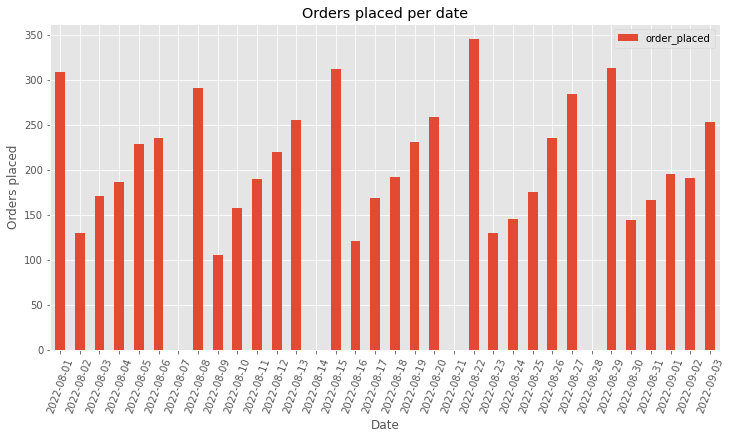

In [42]:
ax = orders_per_day.plot(kind='bar', figsize=(12, 6), rot=70)
ax.set_xticklabels(orders_per_day.index.date)
ax.set_title('Orders placed per date')
ax.set_xlabel('Date')
ax.set_ylabel('Orders placed')
plt.show()

One can clearly see that there is a weekly trend. Let's take a closer look at this trend.

Here we calculate the average orders received at the hub per day of the week. Since exactly 5 weeks of data are provided, the normalization becomes quite easy. Dividing the total by 5 will suffice.

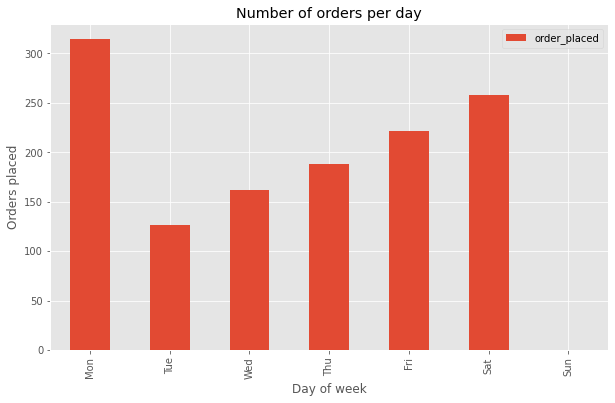

In [43]:
orders_per_weekday = pd.DataFrame(order_data["order_placed"].groupby(order_data["order_placed"].dt.dayofweek).count()/5)

days_of_week_list = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
ax = orders_per_weekday.plot(kind="bar", figsize=(10, 6))
ax.set_title("Number of orders per day")
ax.set_xlabel("Day of week")
ax.set_ylabel("Orders placed")
ax.set_xticks(range(7))
ax.set_xticklabels(days_of_week_list)
ax.set_xlim(-0.5,6.5)
plt.show()

Here we see that Monday is the busiest day at this hub. For the rest of the week, the number of orders per day grows linearly. The hub is closed on Sundays.

Now let's take a look at the number of orders per hour.

In [44]:
t_index = pd.DatetimeIndex(pd.date_range(start='1900-01-01', end='1900-01-01 23:00:00', freq="1h"))

orders_placed_ph = pd.DataFrame(order_data["order_placed"].groupby(order_data["order_placed"].dt.hour).count())
orders_placed_ph.index.names = ['time']
orders_placed_ph.index = pd.to_datetime(orders_placed_ph.index, format='%H')
orders_placed_ph = orders_placed_ph.resample('1H').sum().reindex(t_index).fillna(0)

orders_delivered_ph = pd.DataFrame(order_data["order_delivered"].groupby(order_data["order_delivered"].dt.hour).count())
orders_delivered_ph.index.names = ['time']
orders_delivered_ph.index = pd.to_datetime(orders_delivered_ph.index, format='%H')
orders_delivered_ph = orders_delivered_ph.resample('1H').sum().reindex(t_index).fillna(0)

orders_ph = pd.concat([orders_placed_ph, orders_delivered_ph], axis=1)

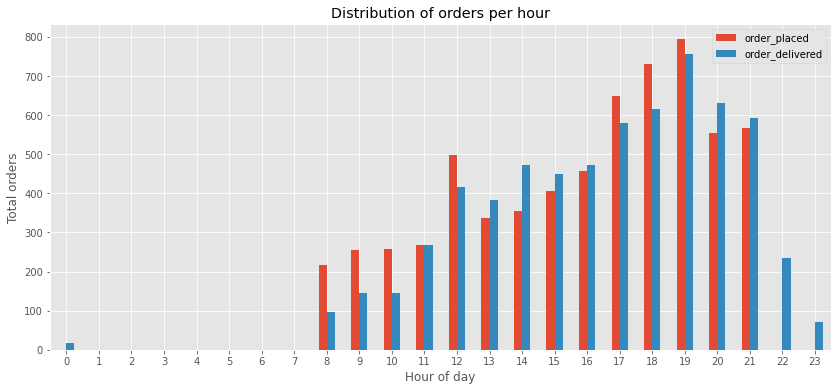

In [45]:
ax = orders_ph.plot(kind='bar', figsize=(14, 6), rot=0)
ax.set_xticklabels(orders_ph.index.hour)
ax.set_title("Distribution of orders per hour")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Total orders")
plt.show()

**What are the opening hours of the hub?** Here we see that the hub is accepting orders from 8:00 until 22:00, as at other times there are no orders being placed. However, orders are still being delivered, the latest deliveries being done past midnight, probably having been delayed due to circumstances. 

Interesting to see is the increasing trend. During the day, when people are working, not many orders are made. However, people have to have lunch, hence the peak at around 12:00. Furthermore, it appears that after 17:00, there is a general lack of workers, and so deliveries pile up, leading to increased delivery times. I also imagine that the profile looks quite different during weekdays than during the weekend.

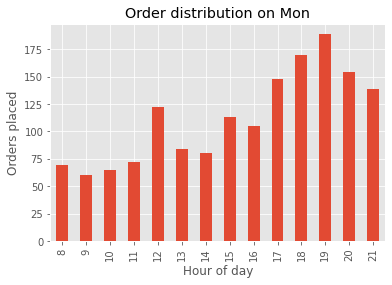

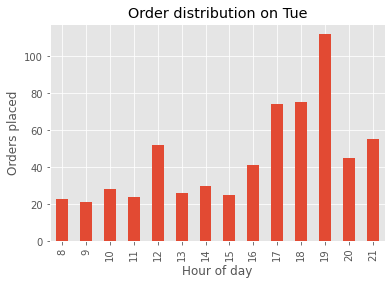

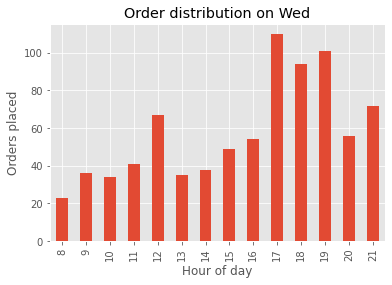

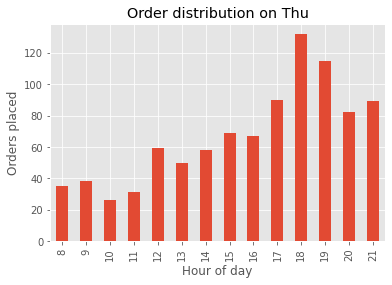

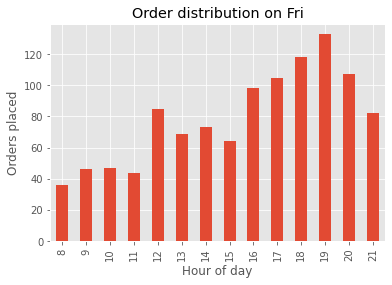

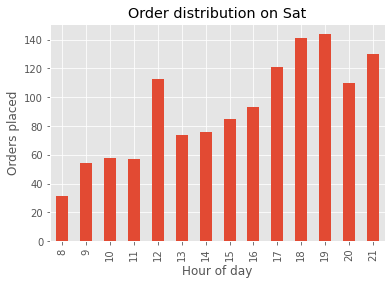

In [46]:
df = order_data["order_placed"].groupby(order_data["order_placed"].dt.dayofweek)
orders_placed_per_weekday = [pd.DataFrame(df.get_group(x)) for x in df.groups]

def plot_order_distribution(df, day):
    fig, ax = plt.subplots(figsize=(6,4))
    df['order_placed'].groupby(df["order_placed"].dt.hour).count().plot(kind="bar", xlim=(6,23))
    ax.set_title(f"Order distribution on {days_of_week_list[day]}")
    ax.set_xlabel("Hour of day")
    ax.set_ylabel('Orders placed')
    plt.show()

for day, df in enumerate(orders_placed_per_weekday):
    plot_order_distribution(df, day)

Turns out there isn't a huge difference. The only notable difference is the relatively lower number of orders on Saturday at 8AM, when people are likely to still be sleeping, but even that might be caused by low number statistics.



# 2. Delivery times exploration

Now is time to explore the time taken to deliver orders.

In [47]:
order_data['delivery_time_mins'] = (order_data['order_delivered'] - order_data['order_placed']).dt.total_seconds()/60
order_data

,order_placed,order_delivered,delivery_time_mins
0,2022-08-01 08:06:41.346543784,2022-08-01 08:23:31.337619,16.833185
1,2022-08-01 08:07:34.938402556,2022-08-01 08:23:38.968821,16.067174
2,2022-08-01 08:08:01.069790706,2022-08-01 08:48:55.124299,40.900908
3,2022-08-01 08:14:35.636039277,2022-08-01 08:49:39.357261,35.062020
4,2022-08-01 08:19:35.254192221,2022-08-01 09:11:39.440481,52.069771
...,...,...,...
6430,2022-09-03 21:51:48.435694009,2022-09-03 22:06:27.706591,14.654515
6431,2022-09-03 21:53:15.635336387,2022-09-03 22:07:16.065865,14.007175
6432,2022-09-03 21:53:45.230095174,2022-09-03 22:07:09.349869,13.401996
6433,2022-09-03 21:54:32.493565029,2022-09-03 22:12:35.598858,18.051755


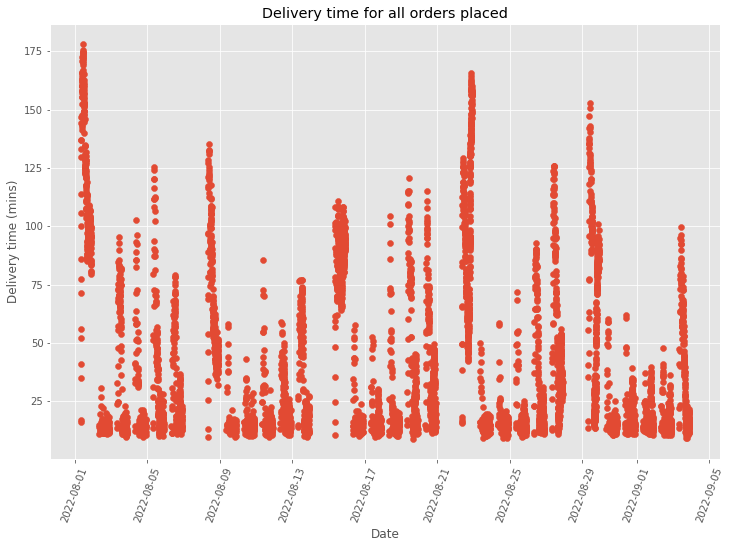

In [48]:
fig = plt.figure(figsize=(12,8))
plt.scatter(order_data['order_placed'], order_data['delivery_time_mins'])
plt.xlabel('Date')
plt.ylabel('Delivery time (mins)')
plt.title('Delivery time for all orders placed')
plt.xticks(rotation=70)
plt.show()

Here we can see that at peak traffic, the delivery time increases. This is especially visible on the busiest day at the hub, Mondays (first peak of the week). We'll take a closer look at these slow deliveries later on. But first, let's try to learn some more about the distribution of the delivery times. I'll start with the average delivery time throughout the day.

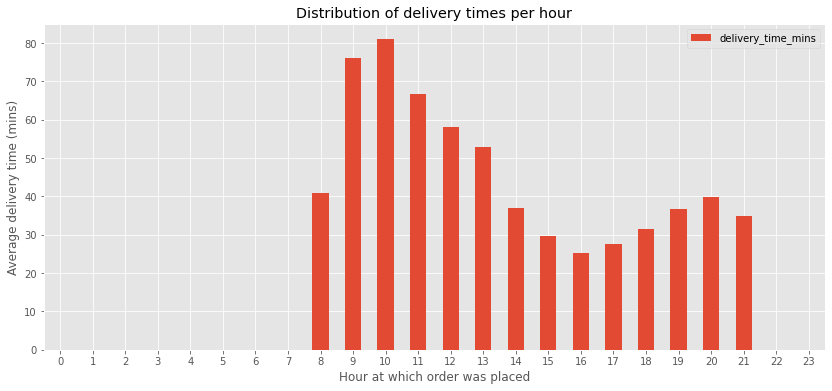

In [49]:
delivery_times_ph = pd.DataFrame(order_data["delivery_time_mins"].groupby(order_data["order_placed"].dt.hour).mean())
delivery_times_ph.index.names = ['time']
delivery_times_ph.index = pd.to_datetime(delivery_times_ph.index, format='%H')
delivery_times_ph = delivery_times_ph.resample('1H').sum().reindex(t_index).fillna(0)

ax = delivery_times_ph.plot(kind='bar', figsize=(14, 6), rot=0)
ax.set_xticklabels(delivery_times_ph.index.hour)
ax.set_title("Distribution of delivery times per hour")
ax.set_xlabel("Hour at which order was placed")
ax.set_ylabel("Average delivery time (mins)")
plt.show()

Here we see that the average delivery time at this hub is highest in the morning, as the average order placed between 9:00 and 11:00 would take aroung 75 minutes to be delivered. Let's analyze the distribution of delivery times.

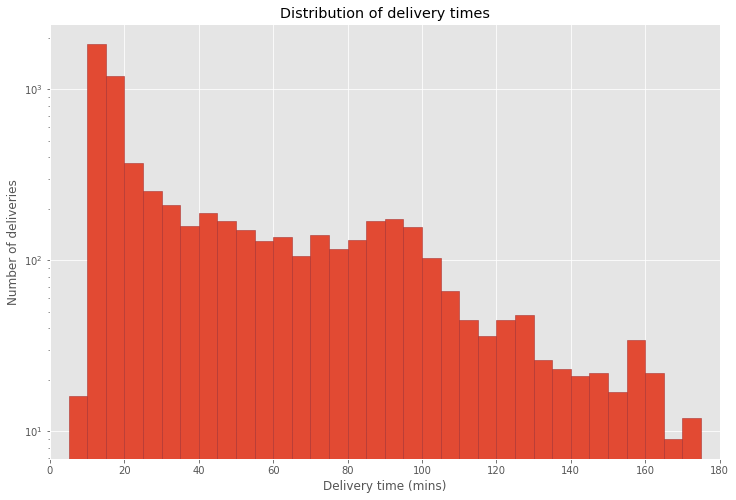

In [50]:
bin_range = np.arange(0, 180, 5)
count, bins = np.histogram(order_data['delivery_time_mins'], bins=bin_range)

fig, ax = plt.subplots(figsize=(12,8))
ax.hist(bins[:-1], bins, weights=count, edgecolor='brown')
ax.set_xlim(0, 180)
ax.set_xlabel('Delivery time (mins)')
ax.set_ylabel('Number of deliveries')
ax.set_title('Distribution of delivery times')
plt.yscale('log')
plt.show()

We see that most orders are delivered within the first 30 mins, but have ranged up to almost 3 hours. Let's look at the mean of the distribution. To calculate this I will use bootstrapping in order to get a confidence interval for the mean.

In [51]:
def bootstrap_find_mean(data, num_itr=5000, num_sample=500, alpha=0.05):
    """ Return the confidence interval of the mean through bootstrapping """
    mean_dist = []
    for _ in range(num_itr):
        x = np.random.choice(data, size=num_sample, replace=True)
        mean_dist.append(x.mean())
    return sms.DescrStatsW(mean_dist).tconfint_mean(alpha=alpha)

mean_l, mean_h = bootstrap_find_mean(order_data['delivery_time_mins'], alpha=0.05)

print(f"With 95% confidence, the mean delivery time lies between {mean_l:.3f} and {mean_h:.3f} minutes")

With 95% confidence, the mean delivery time lies between 41.347 and 41.436 minutes


In order to study when the hub was understaffed, we first have to define understaffed. For my case, I define that data above the upper quartile were slow orders, due to the hub being understaffed. Of course this is just an arbitrary definition based on the available data. There are more factors that go into delivery time, but with the available data this is reasonable to assume.

In [52]:
slow_threshold = order_data['delivery_time_mins'].quantile(0.75)

print(f"75% of orders were delivered in under {slow_threshold:.3f} minutes. Anything above this is a slow order.")

75% of orders were delivered in under 62.834 minutes. Anything above this is a slow order.


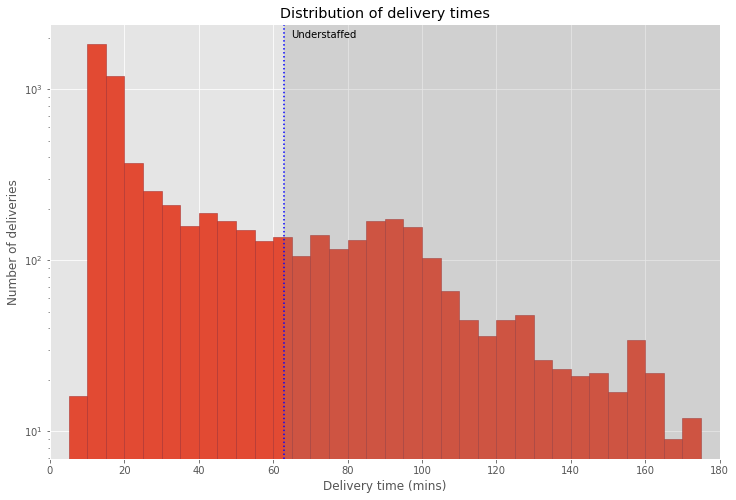

In [53]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(bins[:-1], bins, weights=count, edgecolor='brown')
ax.axvline(slow_threshold, color='blue', ls=':')
ax.axvspan(slow_threshold, 180, alpha=0.2, color='gray')
ax.text(slow_threshold+2, 2000, "Understaffed")
ax.set_xlim(0, 180)
ax.set_xlabel('Delivery time (mins)')
ax.set_ylabel('Number of deliveries')
ax.set_title('Distribution of delivery times')
plt.yscale('log')
plt.show()

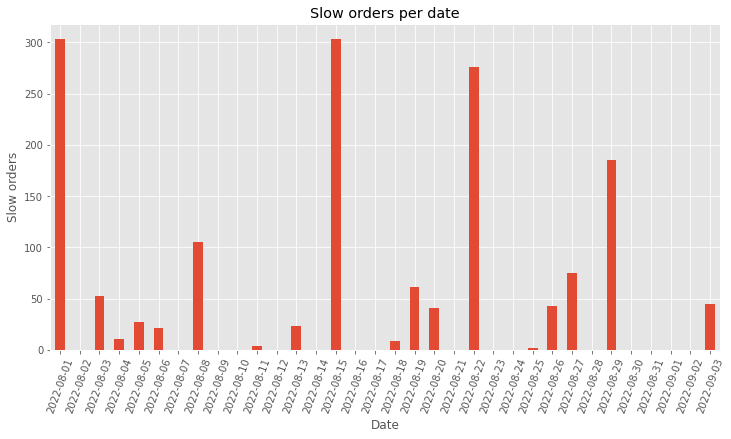

In [54]:
understaffed = order_data[order_data['delivery_time_mins'] >= slow_threshold]

understaffed_dates = pd.DataFrame(understaffed["order_placed"].groupby(understaffed["order_placed"].dt.date).count())
understaffed_dates.index.names = ['date']
understaffed_dates.index = pd.to_datetime(understaffed_dates.index)
understaffed_dates = understaffed_dates.resample('D').sum()

ax = understaffed_dates["order_placed"].plot(kind='bar', figsize=(12, 6), rot=70)
ax.set_xticklabels(understaffed_dates.index.date)
ax.set_title('Slow orders per date')
ax.set_xlabel('Date')
ax.set_ylabel('Slow orders')
plt.show()

Here we see the dates at which the hub was understaffed based on our definition. 

**When was the hub understaffed?** Let's add the problematic dates to a list in descending order, with the most understaffed day first.

In [55]:
understaffed_rank = understaffed_dates[understaffed_dates['order_placed'] > 0].sort_values('order_placed', ascending=False).index
print(understaffed_rank)

DatetimeIndex(['2022-08-01', '2022-08-15', '2022-08-22', '2022-08-29',
               '2022-08-08', '2022-08-27', '2022-08-19', '2022-08-03',
               '2022-09-03', '2022-08-26', '2022-08-20', '2022-08-05',
               '2022-08-13', '2022-08-06', '2022-08-04', '2022-08-18',
               '2022-08-11', '2022-08-25'],
              dtype='datetime64[ns]', name='date', freq=None)


Let's briefly explore the distributions of these understaffed days.

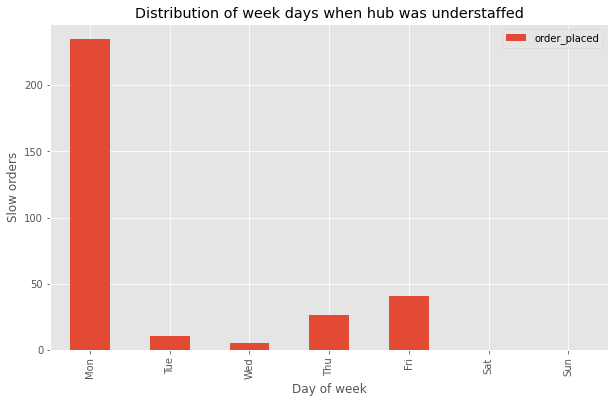

In [56]:
understaffed_per_weekday = pd.DataFrame(understaffed["order_placed"].groupby(understaffed["order_placed"].dt.dayofweek).count()/5)

ax = understaffed_per_weekday.plot(kind="bar", figsize=(10, 6))
ax.set_title("Distribution of week days when hub was understaffed")
ax.set_xlabel("Day of week")
ax.set_ylabel("Slow orders")
ax.set_xticks(range(7))
ax.set_xticklabels(days_of_week_list)
ax.set_xlim(-0.5,6.5)
plt.show()

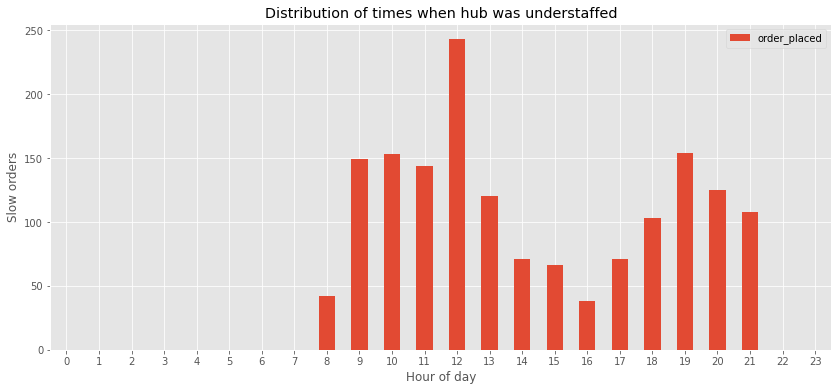

In [57]:
understaffed_ph = pd.DataFrame(understaffed["order_placed"].groupby(understaffed["order_placed"].dt.hour).count())
understaffed_ph.index.names = ['time']
understaffed_ph.index = pd.to_datetime(understaffed_ph.index, format='%H')
understaffed_ph = understaffed_ph.resample('1H').sum().reindex(t_index).fillna(0)

ax = understaffed_ph.plot(kind='bar', figsize=(14, 6), rot=0)
ax.set_xticklabels(understaffed_ph.index.hour)
ax.set_title("Distribution of times when hub was understaffed")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Slow orders")
plt.show()

From these two plots one can see that the hub was understaffed mostly on Mondays (the busiest day of the week), and at time intervals 9:00 - 13:00 and 19:00 - 21:00, with an important peak at around noon.

Lastly, I will try to estimate the distribution of delivery times by finding the best-fitting curve in the `scipy` library. The way I do this is by performing an MLE fit on the data with every curve, and then evaluating the quality of the fit. This evaluation is done by performing a [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).

In [58]:
def find_best_distribution(data):
    """ MLE fit of all distributions in Scipy library on data. 
    Returns best-fitting distribution according to Kolmogorov-Smirnov test. """
    dist_results = []
    params = {}
    for dist_name in [d for d in _distn_names if not d in ['studentized_range', 'levy_stable']]: # Avoid these curves as fit takes long to converge
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            try:
                dist = getattr(sps, dist_name)
                param = dist.fit(data) # MLE fit on data
                params[dist_name] = param
                # Applying the Kolmogorov-Smirnov test
                D, p = sps.kstest(data, dist_name, args=param)
                print("p value for "+dist_name+" = "+str(p))
                dist_results.append((dist_name, p))
            except Exception:
                print("No fit for "+dist_name)

    best_dist, best_p = (max(dist_results, key=lambda x: x[1]))
    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))
    args = params[best_dist][:-2]
    loc = params[best_dist][-2]
    scale = params[best_dist][-1]
    return best_dist, args, loc, scale

In [59]:
best_dist, args, loc, scale = find_best_distribution(order_data['delivery_time_mins'])

p value for ksone = 0.0
No fit for kstwo
p value for kstwobign = 5.568037232619985e-302
p value for norm = 1.949979329442091e-257
p value for alpha = 1.0037409200656735e-93
p value for anglit = 0.0
p value for arcsine = 0.0
p value for beta = 4.121623978851535e-138
p value for betaprime = 1.0632407448860818e-110
p value for bradford = 0.0
p value for burr = 1.2766288155840362e-55
p value for burr12 = 1.5399659934291982e-54
p value for fisk = 1.9520149343174088e-64
p value for cauchy = 0.0
p value for chi = 4.2960525229986095e-148
p value for chi2 = 0.0
p value for cosine = 0.0
p value for dgamma = 7.187127279455665e-241
p value for dweibull = 0.0
p value for expon = 1.2638263585170667e-208
p value for exponnorm = 6.199280514508664e-278
p value for exponweib = 7.465015149596034e-71
p value for exponpow = 7.370348285065821e-128
p value for fatiguelife = 2.5565221895693278e-76
p value for foldcauchy = 5.70789541340918e-74
p value for f = 8.74318676370045e-59
p value for foldnorm = 0.0
p v

In [60]:
def get_stats(dist, args, loc, scale, size=5000):
    """ Get the statistics of dist given the distribution's parameters.
    Also return the probability density function """
    dist = getattr(sps, dist)
    start = dist.ppf(0.0001, *args, loc=loc, scale=scale) if args else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.999, *args, loc=loc, scale=scale) if args else dist.ppf(0.99, loc=loc, scale=scale)
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *args)
    pdf = pd.Series(y, x)
    mean = dist.stats(*args, moments='m')
    conf_interval = dist.interval([0.75], *args) # Get 1-sigma confidence interval
    return pdf, mean, conf_interval

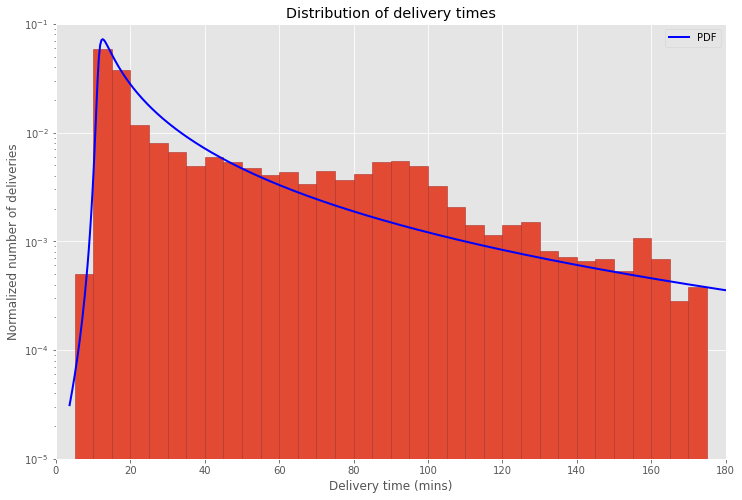

In [61]:
pdf, mean, conf_interval = get_stats(best_dist, args, loc, scale)

fig = plt.figure(figsize=(12,8))
plt.hist(bins[:-1], bins, weights=count, edgecolor='brown', density=True)
ax = pdf.plot(lw=2, label='PDF', legend=True, color='blue')
plt.xlim(0, 180)
plt.xlabel('Delivery time (mins)')
plt.ylabel('Normalized number of deliveries')
plt.title('Distribution of delivery times')
plt.ylim(10**(-5), 10**(-1))
plt.yscale('log')
plt.show()

The fit approximates the distribution, but is not perfect. More data points are needed to draw more detailed conclusions.

# Chapter 3

Here I explain the methodology used in the script to detect abnormal hub closures and estimate the numbers of orders missed. The script can be executed in `script/main.py`.

1. To estimate the hub's abnormal closures, I first get the time gap between orders. If this gap is larger than 3 sigmas over the average gap ($\delta t > \mu + 3\sigma$), I define that the hub is closed due to some issue (this definition can of course be easily changed to be more or less strict.
1. To estimate the number of orders missed, I first have to create the expected distribution of orders throughout the day. In the data exploration section I saw that this distribution greatly varies per day of the week, and so this has to be accounted for. I create the distribution by interpolating the average number of orders per hour (per day of the week). 
1. Then, for every time gap calculated in the previous step, I integrate this distribution to get a number of orders expected based on that time gap, which have been missed due to the hub's closure.